In [1]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
import math
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)


from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder


from pyspark.ml.feature import VectorAssembler


from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder


from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.clustering import KMeans

from pyspark.ml.classification import RandomForestClassifier

In [2]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [1]:
%matplotlib inline

import pandas as pd 
import numpy as np

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics

import matplotlib.pyplot as plt

In [4]:
!ls 

bikeDF2.csv       createDF.ipynb    status.csv        weather.csv
bikeFinalDF.csv   derby.log         status.csv.zip
bikeFinalDF1.csv  metastore_db      trip.csv
bike_pandas.ipynb station.csv       trip.csv.zip


In [2]:
file1= 'station.csv'
file2= 'status.csv'
file3= 'trip.csv'
file4= 'weather.csv'

In [3]:
stationDtype = {
    'id': 'int32',
    'name':'object',
    'lat':'float32',
    'long':'float32',
    'dock_count':'float32',
    'city':'object'}

In [4]:
stationRaw = pd.read_csv(file1, parse_dates=['installation_date'], dtype=stationDtype)

In [5]:
stationRaw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 7 columns):
id                   70 non-null int32
name                 70 non-null object
lat                  70 non-null float32
long                 70 non-null float32
dock_count           70 non-null float32
city                 70 non-null object
installation_date    70 non-null datetime64[ns]
dtypes: datetime64[ns](1), float32(3), int32(1), object(2)
memory usage: 2.8+ KB


In [6]:
stationRaw.values.tolist()

[[2,
  'San Jose Diridon Caltrain Station',
  37.32973098754883,
  -121.90177917480469,
  27.0,
  'San Jose',
  Timestamp('2013-08-06 00:00:00')],
 [3,
  'San Jose Civic Center',
  37.33069610595703,
  -121.88897705078125,
  15.0,
  'San Jose',
  Timestamp('2013-08-05 00:00:00')],
 [4,
  'Santa Clara at Almaden',
  37.333988189697266,
  -121.89490509033203,
  11.0,
  'San Jose',
  Timestamp('2013-08-06 00:00:00')],
 [5,
  'Adobe on Almaden',
  37.33141326904297,
  -121.89320373535156,
  19.0,
  'San Jose',
  Timestamp('2013-08-05 00:00:00')],
 [6,
  'San Pedro Square',
  37.33671951293945,
  -121.89407348632812,
  15.0,
  'San Jose',
  Timestamp('2013-08-07 00:00:00')],
 [7,
  'Paseo de San Antonio',
  37.333797454833984,
  -121.8869400024414,
  15.0,
  'San Jose',
  Timestamp('2013-08-07 00:00:00')],
 [8,
  'San Salvador at 1st',
  37.33016586303711,
  -121.88583374023438,
  15.0,
  'San Jose',
  Timestamp('2013-08-05 00:00:00')],
 [9,
  'Japantown',
  37.3487434387207,
  -121.8947143

In [11]:
!pip install zipcode

    100% |████████████████████████████████| 1.6MB 391kB/s eta 0:00:01
  Running setup.py bdist_wheel for haversine ... done
  Stored in directory: /Users/Yimei/Library/Caches/pip/wheels/be/a3/4e/2e073dc725bf9b430e2d42931c55e5be2be4cdc6e325e17677
Successfully built haversine


In [12]:
import zipcode

In [13]:
!pip install geopy

    100% |████████████████████████████████| 71kB 2.8MB/s ta 0:00:01


In [14]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
location = geolocator.reverse("37.32973098754883,-121.90177917480469")
print(location.address)

San Jose Diridon Caltrain Station, Crandall Street, Little Italy, Buena Vista, San José, Santa Clara County, California, 95110, United States of America


In [6]:
statusDtype = {
    'station_id':'int32',
    'bikes_available':'int32', 
    'docks_available':'int32'}

In [10]:
#statusRaw = pd.read_csv(file2, parse_dates=['time'], dtype=statusDtype)

In [11]:
#statusRaw.head()

In [12]:
#statusRaw.dtypes

In [7]:
tripDtype = {
    'id':'int32',
    'duration':'int32', 
    'start_station_name':'object',
    'end_station_name':'object',
    'end_station_id':'int32',
    'bike_id':'int32',
    'subscription_type': 'object',
    'zip_code': 'str'}

In [8]:
tripRaw = pd.read_csv(file3, parse_dates=['start_date', 'end_date'], na_values=['NaN'], dtype=tripDtype)

In [9]:
tripRaw.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,2013-08-29 14:42:00,San Jose City Hall,10,2013-08-29 14:43:00,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,2013-08-29 10:16:00,Mountain View City Hall,27,2013-08-29 10:17:00,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,2013-08-29 11:29:00,San Jose City Hall,10,2013-08-29 11:30:00,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103


In [10]:
type(tripRaw['zip_code'][0])

str

In [11]:
weatherDtype = {'zip_code': 'str'}

In [12]:
weatherRaw = pd.read_csv(file4, parse_dates=['date'],dtype=weatherDtype)

In [13]:
type(weatherRaw['zip_code'][0])

str

In [14]:
weatherRaw.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


In [15]:
# avg demand and total demand by weather

weather = weatherRaw[['date', 'events', 'zip_code']]
trip = tripRaw[['start_date','id', 'zip_code']]

In [16]:
weather.dtypes

date        datetime64[ns]
events              object
zip_code            object
dtype: object

In [17]:
trip.dtypes

start_date    datetime64[ns]
id                     int32
zip_code              object
dtype: object

In [18]:
weather

,date,events,zip_code
0,2013-08-29,NaN,94107
1,2013-08-30,NaN,94107
2,2013-08-31,NaN,94107
3,2013-09-01,NaN,94107
4,2013-09-02,NaN,94107
5,2013-09-03,NaN,94107
6,2013-09-04,NaN,94107
7,2013-09-05,NaN,94107
8,2013-09-06,NaN,94107
9,2013-09-07,NaN,94107


In [19]:
trip['start_date'] = trip['start_date'].dt.floor('d')

/Users/Yimei/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
weather = weatherRaw[['date', 'events', 'zip_code']]
weather['events'] = weather['events'].fillna('Sunny')
trip = tripRaw[['start_date','id', 'zip_code']]

/Users/Yimei/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
weatherTrip = weather.merge(trip,how='left', left_on = ['date', 'zip_code'], right_on = ['start_date', 'zip_code'])

In [22]:
weatherTrip['events'] = weatherTrip['events']
weatherTrip = weatherTrip.groupby([weatherTrip['events']]).count()

In [23]:
d = {'Total Trips': weatherTrip['date']}

In [24]:
total_trip = pd.DataFrame(data=d)

In [25]:
total_trip.index.names = ['Weather Condition']

In [26]:
total_trip

,Total Trips
Weather Condition,
Fog,112
Fog-Rain,17
Rain,388
Rain-Thunderstorm,3
Sunny,3145
rain,2


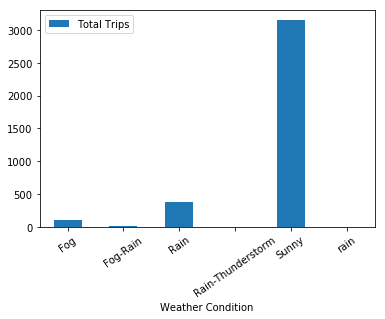

In [27]:
plt.figure()
total_trip.plot(kind='bar', rot=35)


In [47]:
# Final DataFrame 
#1. group trip by 'date' and 'id'
tripRaw['start_date'] = tripRaw['start_date'].dt.floor('d')

In [35]:
tripRaw.columns

Index([u'id', u'duration', u'start_date', u'start_station_name',
       u'start_station_id', u'end_date', u'end_station_name',
       u'end_station_id', u'bike_id', u'subscription_type', u'zip_code'],
      dtype='object')

In [36]:
tripAgg = tripRaw.groupby(['start_date','zip_code', 'start_station_name'], as_index=False)['id'].count()

In [37]:
tripAgg=tripAgg.rename(columns={'id': "num_trips"})

In [38]:
tripAgg.head()

,start_date,zip_code,start_station_name,num_trips
0,2013-08-29,10003,California Ave Caltrain Station,2
1,2013-08-29,10003,University and Emerson,2
2,2013-08-29,10009,Commercial at Montgomery,1
3,2013-08-29,10009,Mechanics Plaza (Market at Battery),1
4,2013-08-29,10009,South Van Ness at Market,1


In [39]:
tripRaw.loc[tripRaw['zip_code']== '94103']

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
4,4299,83,2013-08-29,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103
8,4760,113,2013-08-29,South Van Ness at Market,66,2013-08-29 17:03:00,South Van Ness at Market,66,553,Subscriber,94103
17,4329,142,2013-08-29,Market at 10th,67,2013-08-29 12:14:00,Market at 10th,67,319,Subscriber,94103
47,4824,207,2013-08-29,Market at 10th,67,2013-08-29 17:42:00,South Van Ness at Market,66,632,Subscriber,94103
60,4765,228,2013-08-29,South Van Ness at Market,66,2013-08-29 17:08:00,Market at 10th,67,553,Subscriber,94103
121,4941,337,2013-08-29,Embarcadero at Vallejo,48,2013-08-29 19:11:00,Harry Bridges Plaza (Ferry Building),50,327,Subscriber,94103
125,4393,343,2013-08-29,Commercial at Montgomery,45,2013-08-29 12:40:00,Market at Sansome,77,319,Subscriber,94103
160,4961,387,2013-08-29,Temporary Transbay Terminal (Howard at Beale),55,2013-08-29 19:28:00,5th at Howard,57,471,Subscriber,94103
167,5050,396,2013-08-29,Powell Street BART,39,2013-08-29 21:07:00,Civic Center BART (7th at Market),72,402,Subscriber,94103
238,4809,489,2013-08-29,Powell Street BART,39,2013-08-29 17:38:00,Market at 10th,67,632,Subscriber,94103


In [40]:
tripRaw.loc[tripRaw['zip_code']== '94105']

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
20,4982,146,2013-08-29,Spear at Folsom,49,2013-08-29 19:44:00,Embarcadero at Bryant,54,542,Subscriber,94105
84,4799,267,2013-08-29,Davis at Jackson,42,2013-08-29 17:24:00,Steuart at Market,74,399,Subscriber,94105
112,5100,323,2013-08-29,Steuart at Market,74,2013-08-29 22:56:00,Spear at Folsom,49,317,Subscriber,94105
127,4300,346,2013-08-29,Post at Kearney,47,2013-08-29 12:09:00,Harry Bridges Plaza (Ferry Building),50,603,Customer,94105
128,4968,346,2013-08-29,Embarcadero at Bryant,54,2013-08-29 19:41:00,Spear at Folsom,49,512,Subscriber,94105
147,4998,374,2013-08-29,Harry Bridges Plaza (Ferry Building),50,2013-08-29 20:04:00,Spear at Folsom,49,276,Subscriber,94105
171,5062,402,2013-08-29,Post at Kearney,47,2013-08-29 21:34:00,Howard at 2nd,63,616,Subscriber,94105
175,4999,405,2013-08-29,Harry Bridges Plaza (Ferry Building),50,2013-08-29 20:04:00,Spear at Folsom,49,282,Subscriber,94105
207,5073,440,2013-08-29,Steuart at Market,74,2013-08-29 21:52:00,Embarcadero at Bryant,54,516,Subscriber,94105
208,4445,441,2013-08-29,Harry Bridges Plaza (Ferry Building),50,2013-08-29 13:06:00,Post at Kearney,47,625,Customer,94105


In [41]:
tripAgg.loc[tripAgg['zip_code'] == '94041']

,start_date,zip_code,start_station_name,num_trips
82,2013-08-29,94041,Mountain View Caltrain Station,1
83,2013-08-29,94041,Mountain View City Hall,1
84,2013-08-29,94041,Redwood City Caltrain Station,1
85,2013-08-29,94041,Redwood City Medical Center,1
86,2013-08-29,94041,San Pedro Square,1
558,2013-08-30,94041,Mountain View Caltrain Station,2
559,2013-08-30,94041,Mountain View City Hall,1
560,2013-08-30,94041,Redwood City Caltrain Station,1
561,2013-08-30,94041,Redwood City Medical Center,1
1015,2013-08-31,94041,Evelyn Park and Ride,3


In [42]:
#2. join with weather
weatherRaw['events'] = weatherRaw['events'].fillna('Sunny')
weatherRaw

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,Sunny,286.0,94107
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,Sunny,291.0,94107
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,Sunny,284.0,94107
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,Sunny,284.0,94107
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,Sunny,277.0,94107
5,2013-09-03,73.0,67.0,60.0,59.0,56.0,51.0,84.0,65.0,46.0,...,10.0,10.0,24.0,15.0,31.0,0,2.0,Sunny,276.0,94107
6,2013-09-04,74.0,68.0,61.0,59.0,57.0,56.0,90.0,72.0,53.0,...,10.0,10.0,29.0,19.0,35.0,0,4.0,Sunny,269.0,94107
7,2013-09-05,72.0,66.0,60.0,57.0,56.0,54.0,90.0,74.0,57.0,...,10.0,10.0,31.0,21.0,37.0,0,3.0,Sunny,270.0,94107
8,2013-09-06,85.0,71.0,56.0,57.0,51.0,45.0,86.0,58.0,29.0,...,10.0,10.0,24.0,8.0,28.0,0,0.0,Sunny,287.0,94107
9,2013-09-07,88.0,73.0,58.0,64.0,54.0,46.0,86.0,59.0,31.0,...,10.0,10.0,21.0,8.0,25.0,0,1.0,Sunny,305.0,94107


In [43]:
weatherRaw.dtypes

date                              datetime64[ns]
max_temperature_f                        float64
mean_temperature_f                       float64
min_temperature_f                        float64
max_dew_point_f                          float64
mean_dew_point_f                         float64
min_dew_point_f                          float64
max_humidity                             float64
mean_humidity                            float64
min_humidity                             float64
max_sea_level_pressure_inches            float64
mean_sea_level_pressure_inches           float64
min_sea_level_pressure_inches            float64
max_visibility_miles                     float64
mean_visibility_miles                    float64
min_visibility_miles                     float64
max_wind_Speed_mph                       float64
mean_wind_speed_mph                      float64
max_gust_speed_mph                       float64
precipitation_inches                      object
cloud_cover         

In [44]:
weatherRaw.groupby(['zip_code'],as_index=False).count()

,zip_code,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,...,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees
0,94041,733,730,730,730,730,730,730,730,730,...,733,733,733,733,733,724,733,733,733,733
1,94063,733,733,733,733,733,733,733,733,733,...,733,733,733,733,733,321,733,733,733,733
2,94107,733,733,733,733,733,733,733,733,733,...,733,733,733,733,733,720,733,733,733,733
3,94301,733,732,732,732,682,682,682,682,682,...,720,720,720,732,732,280,732,732,733,732
4,95113,733,733,733,733,733,733,733,733,733,...,733,733,733,733,733,721,733,733,733,733


In [45]:
#tripAgg['zip_code'].unique()

In [46]:
#tripAgg['zip_code'] = tripAgg['zip_code'].astype('str')
#mask = (tripAgg['zip_code'].str.len() == 5)
#tripAgg = tripAgg.loc[mask]

In [47]:
#tripAgg['zip_code'].unique()

In [48]:
#tripAgg['start_date'] = tripAgg['start_date'].astype('object')
#weatherRaw['date'] = weatherRaw['date'].astype('object')

In [49]:
type(tripAgg['zip_code'][0])

str

In [50]:
type(tripAgg['zip_code'].unique()[1])

str

In [51]:
weatherRaw['zip_code'].unique()

array(['94107', '94063', '94301', '94041', '95113'], dtype=object)

In [52]:
type(weatherRaw['zip_code'].unique()[1])

str

In [53]:
tripAgg.columns

Index([u'start_date', u'zip_code', u'start_station_name', u'num_trips'], dtype='object')

In [54]:
weatherRaw.columns

Index([u'date', u'max_temperature_f', u'mean_temperature_f',
       u'min_temperature_f', u'max_dew_point_f', u'mean_dew_point_f',
       u'min_dew_point_f', u'max_humidity', u'mean_humidity', u'min_humidity',
       u'max_sea_level_pressure_inches', u'mean_sea_level_pressure_inches',
       u'min_sea_level_pressure_inches', u'max_visibility_miles',
       u'mean_visibility_miles', u'min_visibility_miles',
       u'max_wind_Speed_mph', u'mean_wind_speed_mph', u'max_gust_speed_mph',
       u'precipitation_inches', u'cloud_cover', u'events', u'wind_dir_degrees',
       u'zip_code'],
      dtype='object')

In [55]:
stationRaw = stationRaw.rename(columns={'id':'station_id'})

In [56]:
stationRaw

,station_id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329731,-121.901779,27.0,San Jose,2013-08-06
1,3,San Jose Civic Center,37.330696,-121.888977,15.0,San Jose,2013-08-05
2,4,Santa Clara at Almaden,37.333988,-121.894905,11.0,San Jose,2013-08-06
3,5,Adobe on Almaden,37.331413,-121.893204,19.0,San Jose,2013-08-05
4,6,San Pedro Square,37.336720,-121.894073,15.0,San Jose,2013-08-07
5,7,Paseo de San Antonio,37.333797,-121.886940,15.0,San Jose,2013-08-07
6,8,San Salvador at 1st,37.330166,-121.885834,15.0,San Jose,2013-08-05
7,9,Japantown,37.348743,-121.894714,15.0,San Jose,2013-08-05
8,10,San Jose City Hall,37.337391,-121.886993,15.0,San Jose,2013-08-06
9,11,MLK Library,37.335884,-121.885658,19.0,San Jose,2013-08-06


In [57]:
tripWeatherAgg = tripAgg.merge(weatherRaw,how='inner', left_on = ['start_date', 'zip_code'], right_on = ['date', 'zip_code'])

In [58]:
tripWeatherAgg

,start_date,zip_code,start_station_name,num_trips,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,...,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees
0,2013-08-29,94041,Mountain View Caltrain Station,1,2013-08-29,80.0,70.0,64.0,65.0,61.0,...,10.0,10.0,10.0,16.0,5.0,16.0,0,4.0,Sunny,355.0
1,2013-08-29,94041,Mountain View City Hall,1,2013-08-29,80.0,70.0,64.0,65.0,61.0,...,10.0,10.0,10.0,16.0,5.0,16.0,0,4.0,Sunny,355.0
2,2013-08-29,94041,Redwood City Caltrain Station,1,2013-08-29,80.0,70.0,64.0,65.0,61.0,...,10.0,10.0,10.0,16.0,5.0,16.0,0,4.0,Sunny,355.0
3,2013-08-29,94041,Redwood City Medical Center,1,2013-08-29,80.0,70.0,64.0,65.0,61.0,...,10.0,10.0,10.0,16.0,5.0,16.0,0,4.0,Sunny,355.0
4,2013-08-29,94041,San Pedro Square,1,2013-08-29,80.0,70.0,64.0,65.0,61.0,...,10.0,10.0,10.0,16.0,5.0,16.0,0,4.0,Sunny,355.0
5,2013-08-29,94063,Franklin at Maple,2,2013-08-29,80.0,71.0,62.0,63.0,59.0,...,10.0,10.0,10.0,14.0,6.0,17.0,0,5.0,Sunny,313.0
6,2013-08-29,94107,2nd at Folsom,3,2013-08-29,74.0,68.0,61.0,61.0,58.0,...,10.0,10.0,10.0,23.0,11.0,28.0,0,4.0,Sunny,286.0
7,2013-08-29,94107,5th at Howard,1,2013-08-29,74.0,68.0,61.0,61.0,58.0,...,10.0,10.0,10.0,23.0,11.0,28.0,0,4.0,Sunny,286.0
8,2013-08-29,94107,Beale at Market,1,2013-08-29,74.0,68.0,61.0,61.0,58.0,...,10.0,10.0,10.0,23.0,11.0,28.0,0,4.0,Sunny,286.0
9,2013-08-29,94107,Civic Center BART (7th at Market),2,2013-08-29,74.0,68.0,61.0,61.0,58.0,...,10.0,10.0,10.0,23.0,11.0,28.0,0,4.0,Sunny,286.0


In [59]:
# join station
tripWeatherStationAgg = tripWeatherAgg.merge(stationRaw, how='left',left_on=['start_station_name'], right_on=['name'])

In [60]:
tripWeatherStationAgg[tripWeatherStationAgg['start_station_name'] == 'Mountain View Caltrain Station' ]

,start_date,zip_code,start_station_name,num_trips,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,...,cloud_cover,events,wind_dir_degrees,station_id,name,lat,long,dock_count,city,installation_date
0,2013-08-29,94041,Mountain View Caltrain Station,1,2013-08-29,80.0,70.0,64.0,65.0,61.0,...,4.0,Sunny,355.0,28.0,Mountain View Caltrain Station,37.39436,-122.076714,23.0,Mountain View,2013-08-15
36,2013-08-30,94041,Mountain View Caltrain Station,2,2013-08-30,87.0,72.0,63.0,66.0,61.0,...,2.0,Sunny,5.0,28.0,Mountain View Caltrain Station,37.39436,-122.076714,23.0,Mountain View,2013-08-15
53,2013-08-30,94107,Mountain View Caltrain Station,1,2013-08-30,78.0,69.0,60.0,61.0,58.0,...,2.0,Sunny,291.0,28.0,Mountain View Caltrain Station,37.39436,-122.076714,23.0,Mountain View,2013-08-15
99,2013-09-01,94041,Mountain View Caltrain Station,1,2013-09-01,81.0,70.0,61.0,62.0,58.0,...,1.0,Sunny,354.0,28.0,Mountain View Caltrain Station,37.39436,-122.076714,23.0,Mountain View,2013-08-15
123,2013-09-02,94041,Mountain View Caltrain Station,2,2013-09-02,80.0,71.0,66.0,64.0,61.0,...,5.0,Sunny,337.0,28.0,Mountain View Caltrain Station,37.39436,-122.076714,23.0,Mountain View,2013-08-15
166,2013-09-04,94041,Mountain View Caltrain Station,2,2013-09-04,82.0,68.0,56.0,61.0,55.0,...,0.0,Sunny,324.0,28.0,Mountain View Caltrain Station,37.39436,-122.076714,23.0,Mountain View,2013-08-15
200,2013-09-05,94041,Mountain View Caltrain Station,2,2013-09-05,81.0,68.0,56.0,59.0,54.0,...,0.0,Sunny,335.0,28.0,Mountain View Caltrain Station,37.39436,-122.076714,23.0,Mountain View,2013-08-15
222,2013-09-05,94107,Mountain View Caltrain Station,1,2013-09-05,72.0,66.0,60.0,57.0,56.0,...,3.0,Sunny,270.0,28.0,Mountain View Caltrain Station,37.39436,-122.076714,23.0,Mountain View,2013-08-15
240,2013-09-06,94041,Mountain View Caltrain Station,1,2013-09-06,90.0,71.0,54.0,62.0,54.0,...,0.0,Sunny,350.0,28.0,Mountain View Caltrain Station,37.39436,-122.076714,23.0,Mountain View,2013-08-15
261,2013-09-06,94107,Mountain View Caltrain Station,1,2013-09-06,85.0,71.0,56.0,57.0,51.0,...,0.0,Sunny,287.0,28.0,Mountain View Caltrain Station,37.39436,-122.076714,23.0,Mountain View,2013-08-15


In [62]:
tripWeatherStationAgg.to_csv('bikeFinalDF1.csv')

In [63]:
tripWeatherStationAgg = pd.read_csv('bikeFinalDF1.csv')

In [64]:
tripWeatherStationAgg.head()

,Unnamed: 0,start_date,zip_code,start_station_name,num_trips,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,...,cloud_cover,events,wind_dir_degrees,station_id,name,lat,long,dock_count,city,installation_date
0,0,2013-08-29,94041,Mountain View Caltrain Station,1,2013-08-29,80.0,70.0,64.0,65.0,...,4.0,Sunny,355.0,28.0,Mountain View Caltrain Station,37.394360,-122.076714,23.0,Mountain View,2013-08-15
1,1,2013-08-29,94041,Mountain View City Hall,1,2013-08-29,80.0,70.0,64.0,65.0,...,4.0,Sunny,355.0,27.0,Mountain View City Hall,37.389217,-122.081894,15.0,Mountain View,2013-08-16
2,2,2013-08-29,94041,Redwood City Caltrain Station,1,2013-08-29,80.0,70.0,64.0,65.0,...,4.0,Sunny,355.0,22.0,Redwood City Caltrain Station,37.486076,-122.232086,25.0,Redwood City,2013-08-15
3,3,2013-08-29,94041,Redwood City Medical Center,1,2013-08-29,80.0,70.0,64.0,65.0,...,4.0,Sunny,355.0,26.0,Redwood City Medical Center,37.487682,-122.223495,15.0,Redwood City,2013-08-12
4,4,2013-08-29,94041,San Pedro Square,1,2013-08-29,80.0,70.0,64.0,65.0,...,4.0,Sunny,355.0,6.0,San Pedro Square,37.336720,-121.894073,15.0,San Jose,2013-08-07


In [65]:
import holidays
us_holidays = holidays.UnitedStates()
def holiday(date):
   if date in us_holidays:
       return 1
   else:
       return 0
tripWeatherStationAgg["holidays"] = [holiday(x) for x in list(tripWeatherStationAgg["start_date"])]

In [66]:
finalDF = tripWeatherStationAgg

In [67]:
finalDF.head()

,Unnamed: 0,start_date,zip_code,start_station_name,num_trips,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,...,events,wind_dir_degrees,station_id,name,lat,long,dock_count,city,installation_date,holidays
0,0,2013-08-29,94041,Mountain View Caltrain Station,1,2013-08-29,80.0,70.0,64.0,65.0,...,Sunny,355.0,28.0,Mountain View Caltrain Station,37.394360,-122.076714,23.0,Mountain View,2013-08-15,0
1,1,2013-08-29,94041,Mountain View City Hall,1,2013-08-29,80.0,70.0,64.0,65.0,...,Sunny,355.0,27.0,Mountain View City Hall,37.389217,-122.081894,15.0,Mountain View,2013-08-16,0
2,2,2013-08-29,94041,Redwood City Caltrain Station,1,2013-08-29,80.0,70.0,64.0,65.0,...,Sunny,355.0,22.0,Redwood City Caltrain Station,37.486076,-122.232086,25.0,Redwood City,2013-08-15,0
3,3,2013-08-29,94041,Redwood City Medical Center,1,2013-08-29,80.0,70.0,64.0,65.0,...,Sunny,355.0,26.0,Redwood City Medical Center,37.487682,-122.223495,15.0,Redwood City,2013-08-12,0
4,4,2013-08-29,94041,San Pedro Square,1,2013-08-29,80.0,70.0,64.0,65.0,...,Sunny,355.0,6.0,San Pedro Square,37.336720,-121.894073,15.0,San Jose,2013-08-07,0


In [68]:
finalDF['date'] = pd.to_datetime(finalDF['date'])
finalDF['day_of_week'] = finalDF['date'].dt.dayofweek

In [69]:
finalDF.head()

,Unnamed: 0,start_date,zip_code,start_station_name,num_trips,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,...,wind_dir_degrees,station_id,name,lat,long,dock_count,city,installation_date,holidays,day_of_week
0,0,2013-08-29,94041,Mountain View Caltrain Station,1,2013-08-29,80.0,70.0,64.0,65.0,...,355.0,28.0,Mountain View Caltrain Station,37.394360,-122.076714,23.0,Mountain View,2013-08-15,0,3
1,1,2013-08-29,94041,Mountain View City Hall,1,2013-08-29,80.0,70.0,64.0,65.0,...,355.0,27.0,Mountain View City Hall,37.389217,-122.081894,15.0,Mountain View,2013-08-16,0,3
2,2,2013-08-29,94041,Redwood City Caltrain Station,1,2013-08-29,80.0,70.0,64.0,65.0,...,355.0,22.0,Redwood City Caltrain Station,37.486076,-122.232086,25.0,Redwood City,2013-08-15,0,3
3,3,2013-08-29,94041,Redwood City Medical Center,1,2013-08-29,80.0,70.0,64.0,65.0,...,355.0,26.0,Redwood City Medical Center,37.487682,-122.223495,15.0,Redwood City,2013-08-12,0,3
4,4,2013-08-29,94041,San Pedro Square,1,2013-08-29,80.0,70.0,64.0,65.0,...,355.0,6.0,San Pedro Square,37.336720,-121.894073,15.0,San Jose,2013-08-07,0,3


In [71]:
finalDF.drop(['Unnamed: 0', 'start_date', 'name'], axis=1, inplace=True)

In [72]:
y = finalDF['num_trips']
finalDF = finalDF.drop(['num_trips'], axis=1)

In [73]:
finalDF['label'] = y

In [74]:
finalDF.head()

,zip_code,start_station_name,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,...,wind_dir_degrees,station_id,lat,long,dock_count,city,installation_date,holidays,day_of_week,label
0,94041,Mountain View Caltrain Station,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,...,355.0,28.0,37.394360,-122.076714,23.0,Mountain View,2013-08-15,0,3,1
1,94041,Mountain View City Hall,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,...,355.0,27.0,37.389217,-122.081894,15.0,Mountain View,2013-08-16,0,3,1
2,94041,Redwood City Caltrain Station,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,...,355.0,22.0,37.486076,-122.232086,25.0,Redwood City,2013-08-15,0,3,1
3,94041,Redwood City Medical Center,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,...,355.0,26.0,37.487682,-122.223495,15.0,Redwood City,2013-08-12,0,3,1
4,94041,San Pedro Square,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,...,355.0,6.0,37.336720,-121.894073,15.0,San Jose,2013-08-07,0,3,1


In [75]:
finalDF.to_csv('bikeDF2.csv')

In [76]:
schema = StructType([
    StructField('unnamed', IntegerType(), True),
    StructField("zip_code",IntegerType(),True),
    StructField("start_station_name",StringType(),True),
    StructField("date",DateType(),True),
    StructField("max_temperature_f",FloatType(),True),
    StructField("mean_temperature_f",FloatType(),True),
    StructField("min_temperature_f",FloatType(),True),
    StructField("max_dew_point_f",FloatType(),True),
    StructField("mean_dew_point_f",FloatType(),True),
    StructField("min_dew_point_f",FloatType(),True),
    StructField("max_humidity",FloatType(),True),
    StructField("mean_humidity",FloatType(),True),
    StructField("min_humidity",FloatType(),True),
    StructField("max_sea_level_pressure_inches",FloatType(),True),
    StructField("mean_sea_level_pressure_inches",FloatType(),True),
    StructField("min_sea_level_pressure_inches",FloatType(),True),
    StructField("max_visibility_miles",FloatType(),True),
    StructField("mean_visibility_miles",FloatType(),True),
    StructField("min_visibility_miles",FloatType(),True),
    StructField("max_wind_Speed_mph",FloatType(),True),
    StructField("mean_wind_speed_mph",FloatType(),True),
    StructField("max_gust_speed_mph",FloatType(),True),
    StructField("precipitation_inches",FloatType(),True),
    StructField("cloud_cover",FloatType(),True),
    StructField("events",StringType(),True),
    StructField("wind_dir_degrees",FloatType(),True),
    StructField("station_id",FloatType(),True),
    StructField("lat",FloatType(),True),
    StructField("long",FloatType(),True),
    StructField("dock_count",IntegerType(),True),
    StructField("city",StringType(),True),
    StructField("installation_date",DateType(),True),
    StructField("holidays",IntegerType(),True),
    StructField("day_of_week",IntegerType(),True),
    StructField("label",IntegerType(),True)
])

In [77]:
#### modeling
df = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='true') \
    .load('bikeDF2.csv', schema = schema)

In [78]:
df.show(1)

+-------+--------+------------------+----+-----------------+------------------+-----------------+---------------+----------------+---------------+------------+-------------+------------+-----------------------------+------------------------------+-----------------------------+--------------------+---------------------+--------------------+------------------+-------------------+------------------+--------------------+-----------+------+----------------+----------+----+----+----------+----+-----------------+--------+-----------+-----+
|unnamed|zip_code|start_station_name|date|max_temperature_f|mean_temperature_f|min_temperature_f|max_dew_point_f|mean_dew_point_f|min_dew_point_f|max_humidity|mean_humidity|min_humidity|max_sea_level_pressure_inches|mean_sea_level_pressure_inches|min_sea_level_pressure_inches|max_visibility_miles|mean_visibility_miles|min_visibility_miles|max_wind_Speed_mph|mean_wind_speed_mph|max_gust_speed_mph|precipitation_inches|cloud_cover|events|wind_dir_degrees|stati

In [132]:
df = df.drop('unnamed', 'date', 'installation_date', 'city')

In [133]:
df.show(3)

+--------+--------------------+-----------------+------------------+-----------------+---------------+----------------+---------------+------------+-------------+------------+-----------------------------+------------------------------+-----------------------------+--------------------+---------------------+--------------------+------------------+-------------------+------------------+--------------------+-----------+------+----------------+----------+---------+-----------+----------+--------+-----------+-----+
|zip_code|  start_station_name|max_temperature_f|mean_temperature_f|min_temperature_f|max_dew_point_f|mean_dew_point_f|min_dew_point_f|max_humidity|mean_humidity|min_humidity|max_sea_level_pressure_inches|mean_sea_level_pressure_inches|min_sea_level_pressure_inches|max_visibility_miles|mean_visibility_miles|min_visibility_miles|max_wind_Speed_mph|mean_wind_speed_mph|max_gust_speed_mph|precipitation_inches|cloud_cover|events|wind_dir_degrees|station_id|      lat|       long|dock_

In [150]:
df = df.na.drop()

In [151]:
#converting strings to numeric values
from pyspark.ml.feature import StringIndexer

def indexStringColumns(df, cols):
    #variable newdf will be updated several times
    newdf = df
    
    for c in cols:
        #For each given colum, fits StringIndexerModel.
        si = StringIndexer(inputCol=c, outputCol=c+"-num")
        sm = si.fit(newdf)
        #Creates a DataFame by putting the transformed values in the new colum with suffix "-num" 
        #and then drops the original columns.
        #and drop the "-num" suffix. 
        newdf = sm.transform(newdf).drop(c)
        newdf = newdf.withColumnRenamed(c+"-num", c)
    return newdf

dfnumeric = indexStringColumns(df,['start_station_name', 'events', 'dock_count'])

In [152]:
dfnumeric.show(3)

+--------+-----------------+------------------+-----------------+---------------+----------------+---------------+------------+-------------+------------+-----------------------------+------------------------------+-----------------------------+--------------------+---------------------+--------------------+------------------+-------------------+------------------+--------------------+-----------+----------------+----------+---------+-----------+--------+-----------+-----+------------------+------+----------+
|zip_code|max_temperature_f|mean_temperature_f|min_temperature_f|max_dew_point_f|mean_dew_point_f|min_dew_point_f|max_humidity|mean_humidity|min_humidity|max_sea_level_pressure_inches|mean_sea_level_pressure_inches|min_sea_level_pressure_inches|max_visibility_miles|mean_visibility_miles|min_visibility_miles|max_wind_Speed_mph|mean_wind_speed_mph|max_gust_speed_mph|precipitation_inches|cloud_cover|wind_dir_degrees|station_id|      lat|       long|holidays|day_of_week|label|start_st

In [153]:
dfnumeric

DataFrame[zip_code: int, max_temperature_f: float, mean_temperature_f: float, min_temperature_f: float, max_dew_point_f: float, mean_dew_point_f: float, min_dew_point_f: float, max_humidity: float, mean_humidity: float, min_humidity: float, max_sea_level_pressure_inches: float, mean_sea_level_pressure_inches: float, min_sea_level_pressure_inches: float, max_visibility_miles: float, mean_visibility_miles: float, min_visibility_miles: float, max_wind_Speed_mph: float, mean_wind_speed_mph: float, max_gust_speed_mph: float, precipitation_inches: float, cloud_cover: float, wind_dir_degrees: float, station_id: float, lat: float, long: float, holidays: int, day_of_week: int, label: int, start_station_name: double, events: double, dock_count: double]

In [154]:
# Merging the data with Vector Assembler.
from pyspark.ml.feature import VectorAssembler
input_cols = ['zip_code','max_temperature_f','mean_temperature_f','min_temperature_f',
        'max_dew_point_f','mean_dew_point_f','min_dew_point_f','max_humidity','mean_humidity',
        'min_humidity','max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
        'min_sea_level_pressure_inches', 'max_visibility_miles','mean_visibility_miles',
        'min_visibility_miles', 'max_wind_Speed_mph', 'mean_wind_speed_mph',
        'max_gust_speed_mph','precipitation_inches','cloud_cover','wind_dir_degrees',
        'station_id', 'lat','long','holidays','day_of_week','start_station_name',
        'events','dock_count']

#VectorAssembler takes a number of collumn names(inputCols) and output column name (outputCol)
#and transforms a DataFrame to assemble the values in inputCols into one single vector with outputCol.
va = VectorAssembler(outputCol="features", inputCols=input_cols)
#lpoints - labeled data.
df_final = va.transform(dfnumeric).select("features", "label")

In [155]:
dfSets = df_final.randomSplit([0.8, 0.2], 1)
dfTrain = dfSets[0].cache()
dfTest = dfSets[1].cache()

In [159]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(maxDepth=20, maxBins=70)
rfmodel = rf.fit(dfTrain)

In [161]:
from pyspark.ml.evaluation import RegressionEvaluator
rfpredicts = rfmodel.transform(dfTest)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(rfpredicts)
print("RMSE = %d" % rmse)

RMSE = 1
